In [1]:
import sys
import os
#sys.path.insert(0, "/usr/src/app/app")
def import_path(fullpath):
    """ 
    Import a file with full path specification. Allows one to
    import from anywhere, something __import__ does not do. 
    """
    path, filename = os.path.split(fullpath)
    filename, ext = os.path.splitext(filename)
    sys.path.append(path)
    module = __import__(filename)
   # reload(module) # Might be out of date
    del sys.path[-1]
    return module

import_path("/usr/src/app/app")

<module 'app' from '/usr/src/app/app/__init__.py'>

In [2]:
from app.pkg.ml.try_on.preprocessing.aggregator import ClothProcessor
cp = ClothProcessor()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
from app.pkg.ml.auto_clothing_set.autoset import LocalRecSys

from app.pkg.ml.buffer_converters import BytesConverter
from PIL import Image
from app.pkg.models.app.image_category import ImageCategory
import random
bc = BytesConverter()


DATA_PATH = "/usr/src/app/data"
def read_clothes(sub_folder):
    
    images_folder = os.path.join(DATA_PATH, sub_folder)
    assert os.path.exists(images_folder)
    im_paths = os.listdir(images_folder)
    abs_im_path = [os.path.join(images_folder, im_path) for im_path in im_paths]
    return abs_im_path


outerwear_clothes_paths = read_clothes("outerwear") # ["/usr/src/app/data/upper/b_bloose.png", "/usr/src/app/data/upper/b_jacket.png"]
upper_clothes_paths = read_clothes("upper") # [ "/usr/src/app/data/upper/t-shirt-blue.png","/usr/src/app/data/upper/t-shirt-miami.png", "/usr/src/app/data/upper/b_t-shirt-2.png", "/usr/src/app/data/upper/b_t-shirt-3.png", "/usr/src/app/data/upper/t-shirt-dc.png", "/usr/src/app/data/upper/t-shirt-dc2.png", "/usr/src/app/data/upper/t-shirt.png" ]
lower_clothes_paths = read_clothes("lower")  # ["/usr/src/app/data/lower/b_black_jeans.png", "/usr/src/app/data/lower/b_shorts.png", "/usr/src/app/data/lower/jeans-dc.png", "/usr/src/app/data/lower/shorts-dc.png" ]
dress_clothes_paths = read_clothes("dresses") # ["/usr/src/app/data/dresses/1.png", "/usr/src/app/data/dresses/2.png", "/usr/src/app/data/dresses/dress-dc.png"]

user_images = [f"{DATA_PATH}/human/brayan_krenston.png"]

def convert_cloth_to_dict(x, category=None):
    res = []
    for i in x:
        image = Image.open(i)
        im_no_back = cp.model_background(image)
        im_bytes = bc.image_to_bytes(im_no_back)
        res.append({'cloth':im_bytes, 'category':category, "clothes_id":random.randint(0, 9999)})
    return res

def convert_user_to_dict(x):
    res = []
    for i in x:
        image = Image.open(i)
        im_no_back = cp.model_background(image)
        im_bytes = bc.image_to_bytes(im_no_back)
        res.append({'image':im_bytes,})
    return res

#        im_white_back = cp.model_background.replace_background_RGBA(im_no_back)


upper_clothes = convert_cloth_to_dict(upper_clothes_paths, ImageCategory.UPPER_BODY)
lower_clothes = convert_cloth_to_dict(lower_clothes_paths, ImageCategory.LOWER_BODY)
dress_clothes = convert_cloth_to_dict(dress_clothes_paths, ImageCategory.DRESSES)
outerwear_clothes = convert_cloth_to_dict(outerwear_clothes_paths, ImageCategory.UPPER_BODY)
user_images = convert_user_to_dict(user_images)


In [4]:
# upper_clothes

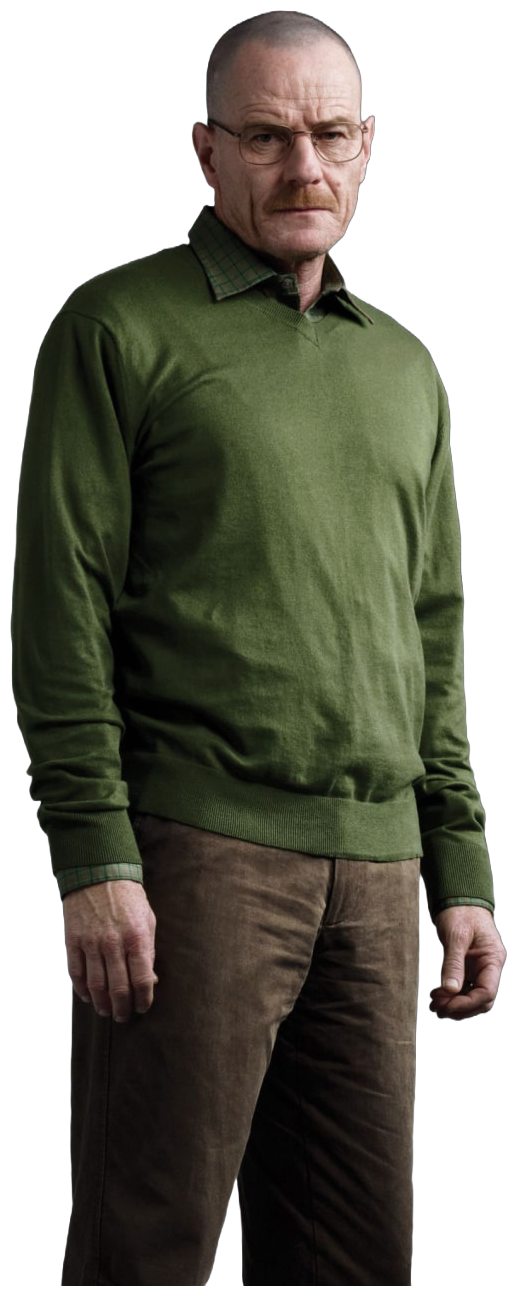

In [5]:
bc.bytes_to_image(user_images[0]['image'])

In [6]:
from typing import Dict, Union, List
import io

import torch
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from torch.nn import Softmax
from PIL import Image
import numpy as np

from app.pkg.ml.buffer_converters import BytesConverter
from app.pkg.ml.try_on.preprocessing.cloth import ClothPreprocessor

In [7]:
def sum_normalize(array):
    if isinstance(array, list):
        array = np.array(array)
    return array/array.sum()
# a = [0.1, 0.4, 0.4]
# sum_normalize(a)

In [11]:
lrs = LocalRecSys(return_cloth_fields = ["clothes_id"])

# score не возвращается, т.к это уже часть outfit. return_cloth_fields - для

In [16]:
outfits = lrs.forward(upper_clothes=upper_clothes,
            lower_clothes=lower_clothes,
            dresses_clothes=dress_clothes,
           # outerwear_clothes=outerwear_clothes,
            prompt = None,#'beachwear',# 'clothes for cinema', # "clothes for theatre",#"beachwear",#"clothes for beach", #"party clothes", #

            sample_amount=10
            )

In [17]:
outfits

[{'clothes': [{'clothes_id': 2671}, {'clothes_id': 3252}]},
 {'clothes': [{'clothes_id': 5642}, {'clothes_id': 6}]},
 {'clothes': [{'clothes_id': 5674}, {'clothes_id': 6062}]},
 {'clothes': [{'clothes_id': 5642}, {'clothes_id': 6062}]},
 {'clothes': [{'clothes_id': 6195}, {'clothes_id': 6}]},
 {'clothes': [{'clothes_id': 2879}, {'clothes_id': 6062}]},
 {'clothes': [{'clothes_id': 2998}, {'clothes_id': 6}]},
 {'clothes': [{'clothes_id': 2671}, {'clothes_id': 6062}]},
 {'clothes': [{'clothes_id': 9143}, {'clothes_id': 6}]},
 {'clothes': [{'clothes_id': 2998}, {'clothes_id': 3252}]}]

In [ ]:
# sf = torch.nn.Softmax(dim=0)

# scores =torch.tensor([outfit['score']/30 for outfit in outfits])
# normalized_scores = sf(scores)

# top_p_scores = None
# top_p_index = None
# top_p = 0.9
# for i, score in enumerate(normalized_scores):
#     if normalized_scores[:i].sum() > top_p:
#         top_p_scores = normalized_scores[:i]
#         top_p_index = i
#         break
# top_p_scores

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,70)
def plot_outfits(outfits_):
    outfits = outfits_[:top_p_index]

    fig, axs = plt.subplots(len(outfits), 3)
    for i, outfit in enumerate(outfits):
        #title =  * 3
        total_score = top_p_scores[i]# outfit['score']
        axs[i,0].set_title(f'total: {total_score}')

        prompt_corr = outfit['prompt_corr']
        axs[i,1].set_title(f'prompt_corr: {prompt_corr}')

        clothes_score = outfit['clothes_score']
        axs[i,2].set_title(f'clothes_score: {clothes_score}')

                           
        for j, cloth in enumerate(outfit['clothes']):
            axs[i, j].imshow(cloth['cloth'])

#    axs[1, 1].scatter(x, y)

plot_outfits(outfits)    

NameError: name 'top_p_index' is not defined

array([0, 4, 2])

<Axes: xlabel='scores', ylabel='Count'>

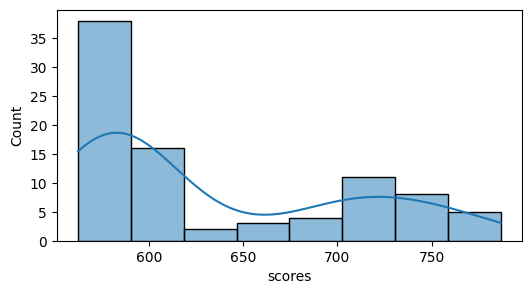

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,3)
import pandas as pd
data = pd.DataFrame({"scores":[outfit['score'] for outfit in outfits]}) # ['scores']
sns.histplot(data=data,
             x="scores",
             kde=True)


([<matplotlib.patches.Wedge at 0x768b9cd03430>,
 [Text(0.9647243562007043, 0.5284949541416046, ''),
  Text(0.09715827957844438, 1.0957008116768725, ''),
  Text(-0.7133772084498623, 0.8373129393866322, ''),
  Text(-1.048544374557765, 0.33249766101924066, ''),
  Text(-1.0887944009662522, -0.15661019259467138, ''),
  Text(-0.9456206146394553, -0.5619623236204531, ''),
  Text(-0.6848035947201693, -0.8608391467970856, ''),
  Text(-0.3662088580192748, -1.0372516918801429, ''),
  Text(-0.04756871245737705, -1.0989709812343307, ''),
  Text(0.25196729672858215, -1.0707532308516705, ''),
  Text(0.5019929193188124, -0.978776332444638, ''),
  Text(0.6848838669298979, -0.8607752835782112, ''),
  Text(0.8236028212861556, -0.7291628026507422, ''),
  Text(0.9280985232332077, -0.5904516332201473, ''),
  Text(1.0010298714936177, -0.45600350478639035, ''),
  Text(1.045717750978507, -0.34128343834480646, ''),
  Text(1.073372485857655, -0.24056497376750077, ''),
  Text(1.0908457249429946, -0.14161781093348

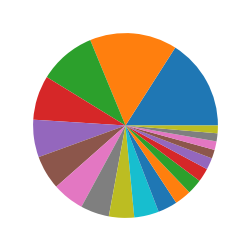

In [ ]:

#data = pd.DataFrame({"scores":top_p_scores.tolist()})
plt.pie(top_p_scores.tolist(), )#, colors = colors, autopct='%.0f%%')
#data